In [1]:
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
from PIL import Image
from skimage import exposure

In [2]:
image_paths = natsorted(glob("data/phantom/images/*.png"))

In [3]:
# plt.style.use("seaborn-v0_8")

Text(0.5, 1.0, 'Brightest image: data/phantom/images/image_328.png')

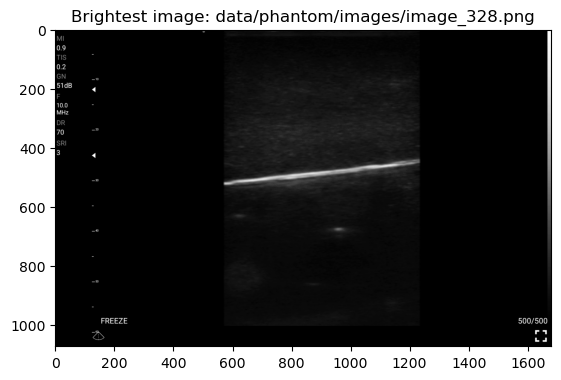

In [4]:
# find and display brightest image

brightest_image = None
brightest_image_brightness = 0

for image_path in image_paths:
    image = Image.open(image_path).convert("L")
    image_arr = np.array(image)
    brightness = np.mean(image_arr)
    if brightness > brightest_image_brightness:
        brightest_image = image_arr
        brightest_image_brightness = brightness
        brightest_image_path = image_path

plt.imshow(image, cmap="gray")
plt.title(f"Brightest image: {brightest_image_path}")

In [5]:
img_histeq = exposure.equalize_hist(image_arr)

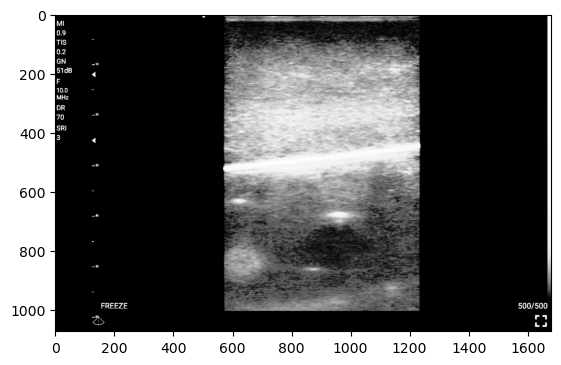

In [6]:
plt.imshow(img_histeq, cmap="gray")

In [19]:
img_histeq.shape

(1072, 1680)

In [50]:
def frame_coords(img):
    img_center = np.array(img.shape) // 2

    # get indices of non-zero rows and columns
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)

    row_indices = np.array(range(img.shape[0]))[rows]
    col_indices = np.array(range(img.shape[1]))[cols]

    print(sorted(row_indices - img_center[0]))
    print(sorted(col_indices - img_center[1]))

In [51]:
frame_coords(img_histeq)

[   0    1    2 ... 1069 1070 1071]
[   0    1    2 ... 1677 1678 1679]
[-535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -535, -53

In [36]:
print(f"Top: {top}, Bottom: {bottom}, Left: {left}, Right: {right}")

Top: -839, Bottom: -839, Left: -536, Right: -536


In [ ]:
import numpy as np


def construct_calibration_matrix(specs):
    # Extract relevant specifications
    axial_pixel_size = specs["axial_resolution"] / 2  # Nyquist theorem
    lateral_pixel_size = specs["lateral_resolution"] / 2  # Nyquist theorem
    depth_range = (specs["blind_zone"], specs["detection_depth"])
    image_width = int(specs["detection_depth"] / lateral_pixel_size)

    min_depth, max_depth = depth_range
    imaging_depth = max_depth - min_depth

    # Calculate number of pixels
    num_axial_pixels = int(imaging_depth / axial_pixel_size)
    num_lateral_pixels = image_width

    # Estimate focal length (mid-point of depth range)
    focal_length = (min_depth + max_depth) / 2

    # Construct the intrinsic matrix
    fx = focal_length / lateral_pixel_size
    fy = focal_length / axial_pixel_size
    cx = num_lateral_pixels / 2
    cy = num_axial_pixels / 2
    intrinsic_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

    # Construct the extrinsic matrix
    rotation = np.eye(3)  # Identity matrix for linear array
    translation = np.array([0, 0, -min_depth]).reshape(3, 1)  # Offset by blind zone
    extrinsic_matrix = np.hstack((rotation, translation))

    # Combine into the full calibration matrix
    calibration_matrix = np.dot(intrinsic_matrix, extrinsic_matrix)

    # Add the homogeneous row
    calibration_matrix = np.vstack((calibration_matrix, [0, 0, 0, 1]))

    return calibration_matrix, num_axial_pixels, num_lateral_pixels


# Specifications
specs = {
    "nominal_frequency": 7.5e6,  # Hz
    "detection_depth": 50,  # mm
    "lateral_resolution": 2,  # mm (at depth <= 40mm)
    "axial_resolution": 0.5,  # mm (at depth <= 50mm)
    "blind_zone": 3,  # mm
    "horizontal_accuracy": 0.05,  # 5%
    "longitudinal_accuracy": 0.05,  # 5%
    "slice_thickness": 5,  # mm
}

calibration_matrix, num_axial_pixels, num_lateral_pixels = construct_calibration_matrix(
    specs
)

print("Refined Calibration Matrix:")
print(calibration_matrix)
print(f"\nEstimated image dimensions: {num_lateral_pixels}x{num_axial_pixels} pixels")
print(
    f"Actual imaging depth: {(specs['detection_depth'] - specs['blind_zone']):.2f} mm"
)